<a href="https://colab.research.google.com/github/mag381/AI/blob/main/02_karaage_%E9%A1%94%E8%A1%A8%E6%83%85%E5%AD%A6%E7%BF%92_%E9%AB%98%E6%80%A7%E8%83%BD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIモデルの性能を性能を上げる方法

## 教師データのダウンロード

ジャンケンの手の形の教師データをGitHubからダウンロード（Clone）します。

2,3行目はダウンロードしたデータから、使用するデータ以外の不要なファイルを削除しています。

In [ ]:
#!git clone https://github.com/karaage0703/janken_dataset datasets
#!rm -rf /content/datasets/.git
#!rm /content/datasets/LICENSE

Cloning into 'datasets'...
remote: Enumerating objects: 210, done.
remote: Total 210 (delta 0), reused 0 (delta 0), pack-reused 210
Receiving objects: 100% (210/210), 4.60 MiB | 20.55 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving data.zip to data.zip


In [ ]:
!unzip data.zip

Archive:  data.zip
   creating: datasets/angry/
  inflating: datasets/angry/KA.AN1.39.jpg  
  inflating: datasets/angry/KA.AN2.40.jpg  
  inflating: datasets/angry/KA.AN3.41.jpg  
  inflating: datasets/angry/KL.AN1.167.jpg  
  inflating: datasets/angry/KL.AN2.168.jpg  
  inflating: datasets/angry/KL.AN3.169.jpg  
  inflating: datasets/angry/KM.AN1.17.jpg  
  inflating: datasets/angry/KM.AN2.18.jpg  
  inflating: datasets/angry/KM.AN3.19.jpg  
  inflating: datasets/angry/KR.AN1.83.jpg  
  inflating: datasets/angry/KR.AN2.84.jpg  
  inflating: datasets/angry/KR.AN3.85.jpg  
  inflating: datasets/angry/MK.AN1.125.jpg  
  inflating: datasets/angry/MK.AN2.126.jpg  
  inflating: datasets/angry/MK.AN3.127.jpg  
  inflating: datasets/angry/NA.AN1.211.jpg  
  inflating: datasets/angry/NA.AN2.212.jpg  
  inflating: datasets/angry/NA.AN3.213.jpg  
  inflating: datasets/angry/NM.AN1.104.jpg  
  inflating: datasets/angry/NM.AN2.105.jpg  
  inflating: datasets/angry/NM.AN3.106.jpg  
  inflating: dat

## 教師データを訓練データ（Train Data）とテストデータ（Validation Data）に分ける

教師データのディレクトリと、ターゲットとなるディレクトリ（この下に訓練データのディレクトリと検証データのディレクトリが生成される）を指定します。

In [ ]:
dataset_original_dir = 'datasets'
dataset_root_dir = 'target_datasets'

教師データを訓練データのディレクトリ(train)と検証データのディレクトリ（val）に分割するスクリプトをダウンロードします。

スクリプトのプログラムに関しては、本ノートブックの主題では無いので割愛します。興味ある方は以下のアドレスで、ソフトの中身を確認して下さい。

https://raw.githubusercontent.com/karaage0703/karaage-ai-book/master/util/split_train_val.py

In [ ]:
!wget https://raw.githubusercontent.com/karaage0703/karaage-ai-book/master/util/split_train_val.py

--2025-05-12 05:24:35--  https://raw.githubusercontent.com/karaage0703/karaage-ai-book/master/util/split_train_val.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2683 (2.6K) [text/plain]
Saving to: ‘split_train_val.py’

split_train_val.py  100%[===================>]   2.62K  --.-KB/s    in 0s      

2025-05-12 05:24:35 (32.9 MB/s) - ‘split_train_val.py’ saved [2683/2683]



In [ ]:
import split_train_val
split_train_val.image_dir_train_val_split(dataset_original_dir, dataset_root_dir, train_size=0.67)

datasets/angry copy is done
datasets/happy copy is done
datasets/neutral copy is done
processing is done


In [ ]:
train_dir = 'target_datasets/train'
val_dir = 'target_datasets/val'

## ラベルファイルの作成

学習するファイルのラベルを作成します

必要なライブラリをインポートします

In [ ]:
import sys
import os
import shutil

データを保存する場所を指定します

In [ ]:
backup_dir = './model'

ラベルデータを作成します（最後に表示される class numberが画像の種類の数です）

In [ ]:
labels = [d for d in os.listdir(dataset_original_dir) \
    if os.path.isdir(os.path.join(dataset_original_dir, d))]
labels.sort()

if os.path.exists(backup_dir):
  shutil.rmtree(backup_dir)

os.makedirs(backup_dir)

with open(backup_dir + '/labels.txt','w') as f:
  for label in labels:
    f.write(label+"\n")

NUM_CLASSES = len(labels)
print("class number=" + str(NUM_CLASSES))

class number=3


ラベルを確認します。ラベル名（choki, gu, pa）が並んでいればOKです

In [ ]:
!cat ./model/labels.txt

angry
happy
neutral


## 学習の事前準備

### ライブラリのインポート

必要なライブラリをインポートします

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.18.0


続いて、他に必要なライブラリをインストールします。

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten

from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import time

先ほど作成したラベルファイルから、ラベル情報を読み込みます

In [ ]:
labels = []
with open(backup_dir + '/labels.txt','r') as f:
    for line in f:
        labels.append(line.rstrip())
print(labels)

NUM_CLASSES = len(labels)

['angry', 'happy', 'neutral']


### 学習のハイパーパラメータの設定

学習のハイパーパラメータの設定をします

In [ ]:
# 学習率
LEARNING_RATE = 0.001
# エポック（世代数）
EPOCHS = 20
# バッチサイズ
BATCH_SIZE = 8

### データセットの前処理

データをTensorFlowで扱える形式に変換します

In [ ]:
IMAGE_SIZE = 64

train_data_gen = ImageDataGenerator(rescale=1./255)
val_data_gen = ImageDataGenerator(rescale=1./255)

train_data = train_data_gen.flow_from_directory(
    train_dir, target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode='rgb', batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=True)

validation_data = val_data_gen.flow_from_directory(
    val_dir, target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode='rgb', batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=True)

Found 58 images belonging to 3 classes.
Found 30 images belonging to 3 classes.


## モデルの変更

In [ ]:
model_2 = Sequential()

model_2.add(Conv2D(32, (3, 3), padding='same', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model_2.add(Activation('relu'))
model_2.add(Conv2D(32, (3, 3)))
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.25))

model_2.add(Conv2D(64, (3, 3), padding='same'))
model_2.add(Activation('relu'))
model_2.add(Conv2D(64, (3, 3)))
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size=(3, 3)))
model_2.add(Dropout(0.25))

model_2.add(Flatten())
model_2.add(Dense(512))
model_2.add(Activation('relu'))
model_2.add(Dropout(0.5))

model_2.add(Dense(NUM_CLASSES))
model_2.add(Activation('softmax'))

opt = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model_2.compile(opt, loss='categorical_crossentropy',
    metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model_2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 62, 62, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 31, 31, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 31, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 29, 29, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 9, 9, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 9, 9, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 5184)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,654,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 3)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,721,827 (10.38 MB)

 Trainable params: 2,721,827 (10.38 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
%%time
history = model_2.fit(train_data, epochs=EPOCHS, validation_data=validation_data, verbose=1)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 206ms/step - accuracy: 0.4193 - loss: 1.1972 - val_accuracy: 0.3000 - val_loss: 1.1004
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 0.2535 - loss: 1.1862 - val_accuracy: 0.3333 - val_loss: 1.0999
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - accuracy: 0.3786 - loss: 1.1081 - val_accuracy: 0.3333 - val_loss: 1.0968
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 0.3775 - loss: 1.0992 - val_accuracy: 0.3333 - val_loss: 1.0982
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 0.3218 - loss: 1.1095 - val_accuracy: 0.3333 - val_loss: 1.0978
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step - accuracy: 0.2985 - loss: 1.1039 - val_accuracy: 0.3333 - val_loss: 1.0985
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 0.3616 - loss: 1.0917 - val_accuracy: 0.3333 - val_loss: 1.0917
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 199ms/step - accuracy: 0.4930 - loss: 1.0792 - val_accuracy: 0.6000 - val_loss: 1.0832
Epo

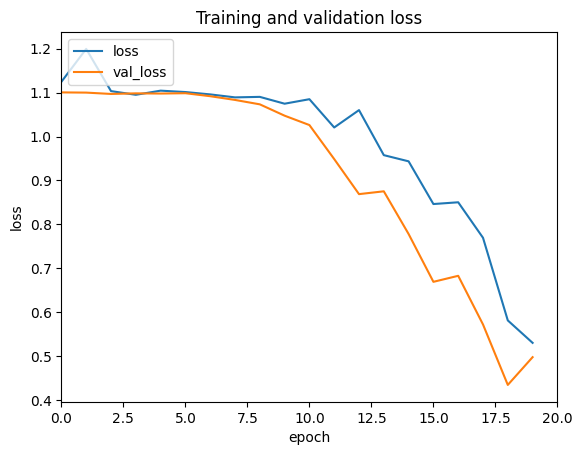

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlim([0.0, EPOCHS])
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()

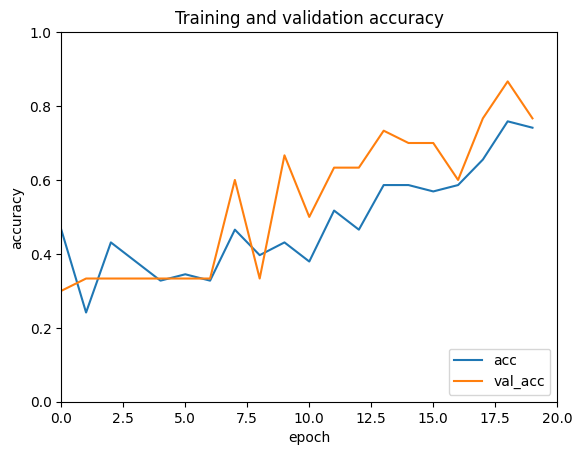

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.xlim([0.0, EPOCHS])
plt.ylim([0.0, 1.0])
plt.legend(['acc', 'val_acc'], loc='lower right')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


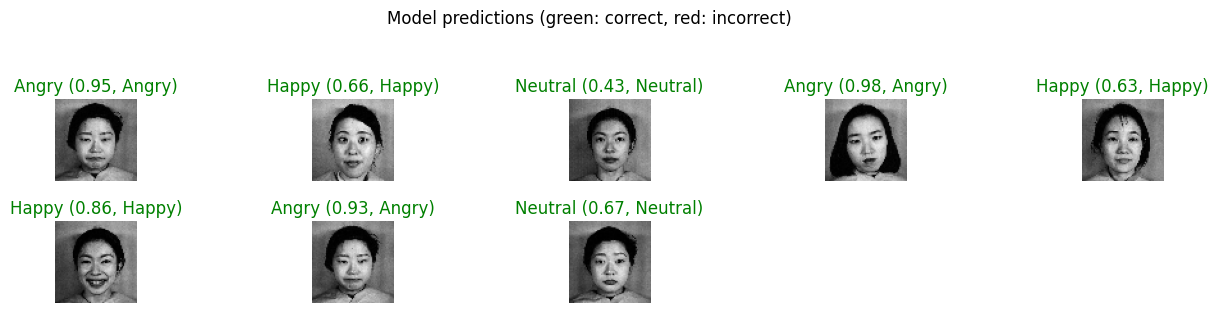

In [ ]:
# Get the ordered list of class names:
import PIL.Image as Image
class_names = validation_data.class_indices.items()
class_names = np.array([key.title() for key, value in class_names])

validation_data.reset()
validation_data.shuffle = True
validation_data.batch_size = BATCH_SIZE

# Retrieve the first batch from the validation data
for validation_image_batch, validation_label_batch in validation_data:
  break

validation_id = np.argmax(validation_label_batch, axis=-1)
validation_label = class_names[validation_id]
predicted_batch = model_2.predict(validation_image_batch)

# Returns the indices of the maximum values along a given axis
predicted_id = np.argmax(predicted_batch, axis=-1)

# Return the maximum values along a given axis
predicted_score = np.max(predicted_batch, axis=-1)

predicted_label_batch = class_names[predicted_id]

plt.figure(figsize=(16, 9))
plt.subplots_adjust(hspace=0.5)

# Display the classification results for the first 30 images
for n in range(min(validation_image_batch.shape[0], 30)):
  plt.subplot(6, 5, n + 1)

  # Convert the range from -1 to 1 to the range from 0 to 1
  plt.imshow(np.array(validation_image_batch[n]*255,np.int32))
  color = 'green' if predicted_id[n] == validation_id[n] else 'red'
  predicted_label = predicted_label_batch[n].title()
  plt.title(predicted_label + ' ({:.2f}, {})'.format(
      predicted_score[n], validation_label[n]), color=color)
  plt.axis('off')

_ = plt.suptitle('Model predictions (green: correct, red: incorrect)')

## 転移学習

### MobileNetV2

MobileNet V2を読み込みます。

In [ ]:
from tensorflow.keras.optimizers import Adam

In [ ]:
mobilenet_pretrained_model = tf.keras.applications.mobilenet_v2.MobileNetV2(
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
    include_top=False,
    weights= 'imagenet')

opt = tf.keras.optimizers.Adam(learning_rate=0.001)

<ipython-input-23-286a2c3e2f7a>:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet_pretrained_model = tf.keras.applications.mobilenet_v2.MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
mobilenet_pretrained_model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 32, 32,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 32, 32,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 32, 32,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 32, 32,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 32, 32,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 32, 32,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 32, 32,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 32, 32,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 32, 32,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 32, 32,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 32, 32,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 33, 33,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 16, 16,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 16, 16,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 16, 16,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 16, 16,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [ ]:
(image_data, _) = train_data.__next__()
feature_batch = mobilenet_pretrained_model(image_data)
print(feature_batch.shape)

(8, 2, 2, 1280)


In [ ]:
mobilenet_pretrained_model.trainable = False

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(8, 1280)


注意： 以下の行`prediction_layer`に活性化層として`softmax`を指定していなかったため書籍では性能が正しく出ていませんでした。指定することで`mobilenet`でも高い性能が出ます。

参考： https://github.com/karaage0703/karaage-ai-book/issues/26

In [ ]:
prediction_layer = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(8, 3)


In [ ]:
mobilenet_train_model = tf.keras.Sequential([
  mobilenet_pretrained_model,
  global_average_layer,
  prediction_layer
])

In [ ]:
mobilenet_train_model.compile(opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
mobilenet_train_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 2, 2, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │         3,843 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,261,827 (8.63 MB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

学習します。

In [ ]:
%%time
history = mobilenet_train_model.fit(train_data, epochs=EPOCHS, validation_data=validation_data, verbose=1)

Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 316ms/step - accuracy: 0.3651 - loss: 2.0563 - val_accuracy: 0.5667 - val_loss: 1.2521
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.2966 - loss: 1.2883 - val_accuracy: 0.6000 - val_loss: 1.0158
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.4447 - loss: 1.1013 - val_accuracy: 0.6667 - val_loss: 1.1169
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.5687 - loss: 0.9414 - val_accuracy: 0.6667 - val_loss: 0.9496
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.5261 - loss: 0.8292 - val_accuracy: 0.7667 - val_loss: 0.9055
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.7562 - loss: 0.6219 - val_accuracy: 0.8000 - val_loss: 0.9455
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.7854 - loss: 0.5599 - val_accuracy: 0.8000 - val_loss: 0.8273
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8080 - loss: 0.5202 - val_accuracy: 0.8000 - val_loss: 0.8797

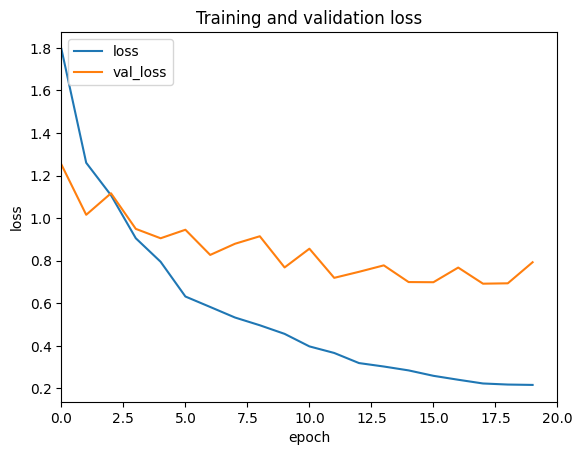

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlim([0.0, EPOCHS])
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()

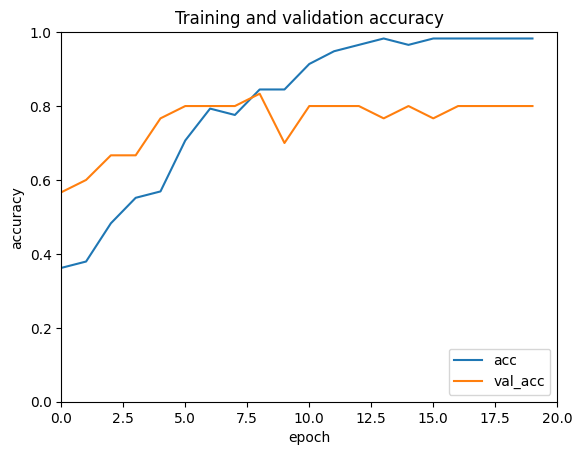

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.xlim([0.0, EPOCHS])
plt.ylim([0.0, 1.0])
plt.legend(['acc', 'val_acc'], loc='lower right')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


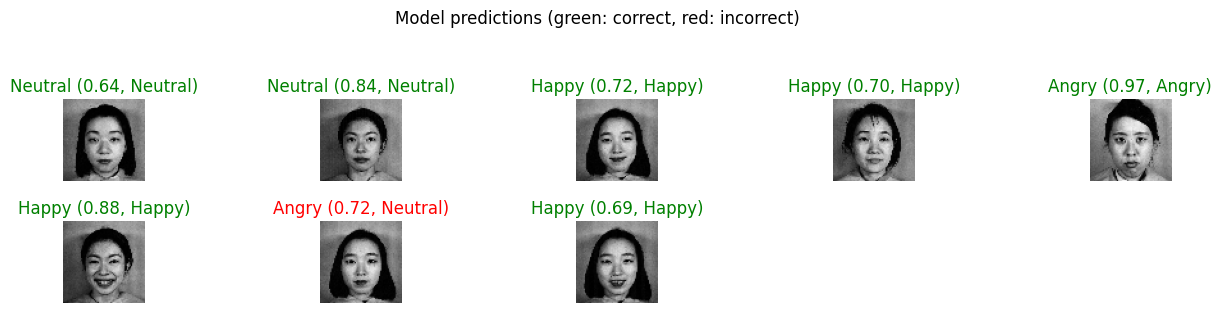

In [ ]:
# Get the ordered list of class names:
import PIL.Image as Image
class_names = validation_data.class_indices.items()
class_names = np.array([key.title() for key, value in class_names])

validation_data.reset()
validation_data.shuffle = True
validation_data.batch_size = BATCH_SIZE

# Retrieve the first batch from the validation data
for validation_image_batch, validation_label_batch in validation_data:
  break

validation_id = np.argmax(validation_label_batch, axis=-1)
validation_label = class_names[validation_id]
predicted_batch = mobilenet_train_model.predict(validation_image_batch)

# Returns the indices of the maximum values along a given axis
predicted_id = np.argmax(predicted_batch, axis=-1)

# Return the maximum values along a given axis
predicted_score = np.max(predicted_batch, axis=-1)

predicted_label_batch = class_names[predicted_id]

plt.figure(figsize=(16, 9))
plt.subplots_adjust(hspace=0.5)

# Display the classification results for the first 30 images
for n in range(min(validation_image_batch.shape[0], 30)):
  plt.subplot(6, 5, n + 1)

  # Convert the range from -1 to 1 to the range from 0 to 1
  plt.imshow(np.array(validation_image_batch[n]*255,np.int32))
  color = 'green' if predicted_id[n] == validation_id[n] else 'red'
  predicted_label = predicted_label_batch[n].title()
  plt.title(predicted_label + ' ({:.2f}, {})'.format(
      predicted_score[n], validation_label[n]), color=color)
  plt.axis('off')

_ = plt.suptitle('Model predictions (green: correct, red: incorrect)')

30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


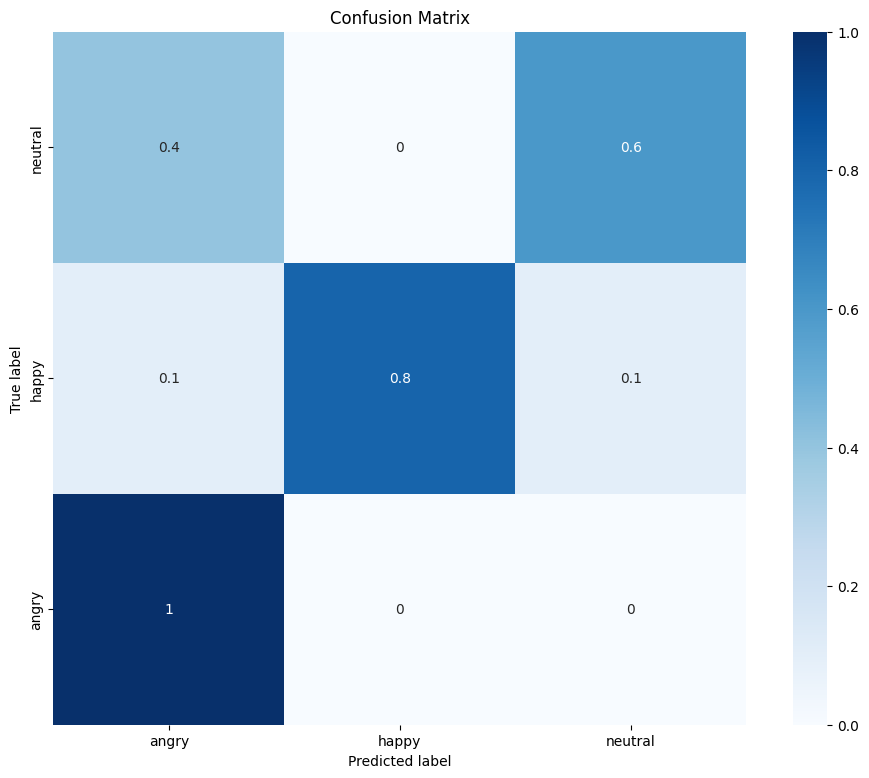

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

validation_data.reset()
validation_data.shuffle =  False
validation_data.batch_size = 1

# Retrieve the first batch from the validation data
for validation_image_batch, validation_label_batch in validation_data:
  break

predicted = mobilenet_train_model.predict(validation_data, steps=validation_data.n)
predicted_classes = np.argmax(predicted, axis=-1)


# Apply normalization
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
cm = confusion_matrix(validation_data.classes, predicted_classes)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12, 9))

# https://seaborn.pydata.org/generated/seaborn.heatmap.html
# https://matplotlib.org/users/colormaps.html
sns.heatmap(cm, annot=True, square=True, cmap=plt.cm.Blues,
            xticklabels=validation_data.class_indices,
            yticklabels=validation_data.class_indices)

plt.title("Confusion Matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.xlim([0.0, 3.0])
plt.ylim([0.0, 3.0])
plt.show()

### EfficientNet

In [ ]:
import tensorflow_hub as hub

In [ ]:
feature_extractor_url = "https://tfhub.dev/google/efficientnet/b0/feature-vector/1" #@param {type:"string"}

In [ ]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

In [ ]:
feature_extractor_layer.trainable = False

In [ ]:
import tf_keras as keras

In [ ]:
# For Fix issue https://github.com/karaage0703/karaage-ai-book/issues/42
#opt = tf.keras.optimizers.legacy.Adam(learning_rate=LEARNING_RATE)
opt = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

In [ ]:
efficientnet_model = keras.Sequential([
  feature_extractor_layer,
  keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [ ]:
efficientnet_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              4049564   
                                                                 
 dense_11 (Dense)            (None, 3)                 3843      
                                                                 
Total params: 4053407 (15.46 MB)
Trainable params: 3843 (15.01 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


In [ ]:
efficientnet_model.compile ( opt,
                           loss='categorical_crossentropy', metrics=['accuracy'])

ValueError: Could not interpret optimizer identifier: <keras.src.optimizers.adam.Adam object at 0x7f2e687e8c50>

In [ ]:
%%time
history = efficientnet_model.fit(train_data, epochs=EPOCHS, validation_data=validation_data, verbose=1)

Epoch 1/20
    156/Unknown - 12s 57ms/step - loss: 0.7861 - accuracy: 0.6896

KeyboardInterrupt: 

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlim([0.0, EPOCHS])
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.xlim([0.0, EPOCHS])
plt.ylim([0.0, 1.1])
plt.legend(['acc', 'val_acc'], loc='lower right')
plt.show()

In [ ]:
# Get the ordered list of class names:
import PIL.Image as Image
class_names = validation_data.class_indices.items()
class_names = np.array([key.title() for key, value in class_names])

validation_data.reset()
validation_data.shuffle = True
validation_data.batch_size = BATCH_SIZE

# Retrieve the first batch from the validation data
for validation_image_batch, validation_label_batch in validation_data:
  break

validation_id = np.argmax(validation_label_batch, axis=-1)
validation_label = class_names[validation_id]
predicted_batch = efficientnet_model.predict(validation_image_batch)

# Returns the indices of the maximum values along a given axis
predicted_id = np.argmax(predicted_batch, axis=-1)

# Return the maximum values along a given axis
predicted_score = np.max(predicted_batch, axis=-1)

predicted_label_batch = class_names[predicted_id]

plt.figure(figsize=(16, 9))
plt.subplots_adjust(hspace=0.5)

# Display the classification results for the first 30 images
for n in range(min(validation_image_batch.shape[0], 30)):
  plt.subplot(6, 5, n + 1)

  # Convert the range from -1 to 1 to the range from 0 to 1
  plt.imshow(np.array(validation_image_batch[n]*255,np.int32))
  color = 'green' if predicted_id[n] == validation_id[n] else 'red'
  predicted_label = predicted_label_batch[n].title()
  plt.title(predicted_label + ' ({:.2f}, {})'.format(
      predicted_score[n], validation_label[n]), color=color)
  plt.axis('off')

_ = plt.suptitle('Model predictions (green: correct, red: incorrect)')

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

validation_data.reset()
validation_data.shuffle =  False
validation_data.batch_size = 1

# Retrieve the first batch from the validation data
for validation_image_batch, validation_label_batch in validation_data:
  break

predicted = efficientnet_model.predict_generator(validation_data, steps=validation_data.n)
predicted_classes = np.argmax(predicted, axis=-1)

# Apply normalization
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
cm = confusion_matrix(validation_data.classes, predicted_classes)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12, 9))

# https://seaborn.pydata.org/generated/seaborn.heatmap.html
# https://matplotlib.org/users/colormaps.html
sns.heatmap(cm, annot=True, square=True, cmap=plt.cm.Blues,
            xticklabels=validation_data.class_indices,
            yticklabels=validation_data.class_indices)

plt.title("Confusion Matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.xlim([0.0, 3.0])
plt.ylim([0.0, 3.0])
plt.show()

## データ水増し

データをデータ水増し用のディレクトリにコピー

In [ ]:
!cp -r ./target_datasets/train ./target_datasets/train_aug
!cp ./datasets/angry/KA.AN1.39.jpg ./target_datasets/train_aug/angry

データ水増し用のディレクトリを定義

In [ ]:
train_aug_dir = 'target_datasets/train_aug'

必要なライブラリをインポート

In [ ]:
import cv2
import numpy as np
import sys
import os
import glob

In [ ]:
# ヒストグラム均一化
def equalizeHistRGB(src):
    RGB = cv2.split(src)
    Blue   = RGB[0]
    Green = RGB[1]
    Red    = RGB[2]
    for i in range(3):
        cv2.equalizeHist(RGB[i])

    img_hist = cv2.merge([RGB[0],RGB[1], RGB[2]])
    return img_hist

# ガウシアンノイズ
def addGaussianNoise(src):
    row,col,ch= src.shape
    mean = 0
    var = 0.1
    sigma = 15
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    noisy = src + gauss

    return noisy

In [ ]:
labels = os.listdir(dataset_original_dir)

image_file_names = []

for label in labels:
  image_files = glob.glob(train_aug_dir + '/' + label +'/*')
  for image_file in image_files:
    image_file_names.append(image_file)

print(image_file_names)

['target_datasets/train_aug/angry/UY.AN1.146.jpg', 'target_datasets/train_aug/angry/KR.AN2.84.jpg', 'target_datasets/train_aug/angry/KM.AN3.19.jpg', 'target_datasets/train_aug/angry/KA.AN3.41.jpg', 'target_datasets/train_aug/angry/KR.AN1.83.jpg', 'target_datasets/train_aug/angry/KM.AN2.18.jpg', 'target_datasets/train_aug/angry/KA.AN2.40.jpg', 'target_datasets/train_aug/angry/KL.AN3.169.jpg', 'target_datasets/train_aug/angry/KA.AN1.39.jpg', 'target_datasets/train_aug/angry/UY.AN2.147.jpg', 'target_datasets/train_aug/angry/NA.AN2.212.jpg', 'target_datasets/train_aug/angry/KM.AN1.17.jpg', 'target_datasets/train_aug/angry/TM.AN3.192.jpg', 'target_datasets/train_aug/angry/MK.AN3.127.jpg', 'target_datasets/train_aug/angry/UY.AN3.148.jpg', 'target_datasets/train_aug/angry/NA.AN1.211.jpg', 'target_datasets/train_aug/angry/MK.AN2.126.jpg', 'target_datasets/train_aug/angry/NM.AN2.105.jpg', 'target_datasets/train_aug/angry/NA.AN3.213.jpg', 'target_datasets/train_aug/angry/YM.AN3.63.jpg', 'target_

In [ ]:
# ルックアップテーブルの生成
min_table = 50
max_table = 205
diff_table = max_table - min_table
gamma1 = 0.75
gamma2 = 1.5

LUT_HC = np.arange(256, dtype = 'uint8')
LUT_LC = np.arange(256, dtype = 'uint8')
LUT_G1 = np.arange(256, dtype = 'uint8')
LUT_G2 = np.arange(256, dtype = 'uint8')

LUTs = []

# 平滑化用
average_square = (10,10)

# ハイコントラストLUT作成
for i in range(0, min_table):
  LUT_HC[i] = 0

for i in range(min_table, max_table):
  LUT_HC[i] = 255 * (i - min_table) / diff_table

for i in range(max_table, 255):
  LUT_HC[i] = 255

# その他LUT作成
for i in range(256):
  LUT_LC[i] = min_table + i * (diff_table) / 255
  LUT_G1[i] = 255 * pow(float(i) / 255, 1.0 / gamma1)
  LUT_G2[i] = 255 * pow(float(i) / 255, 1.0 / gamma2)

LUTs.append(LUT_HC)
LUTs.append(LUT_LC)
LUTs.append(LUT_G1)
LUTs.append(LUT_G2)


for image_file in image_file_names:
#  print(image_file)
  # 画像の読み込み
  img_src = cv2.imread(image_file, 1)
  trans_img = []
  trans_img.append(img_src)

  # LUT変換
  for i, LUT in enumerate(LUTs):
    trans_img.append(cv2.LUT(img_src, LUT))

	# 平滑化
  trans_img.append(cv2.blur(img_src, average_square))

	# ヒストグラム均一化
  trans_img.append(equalizeHistRGB(img_src))

	# ノイズ付加
  trans_img.append(addGaussianNoise(img_src))

	# 反転
  flip_img = []
  for img in trans_img:
     flip_img.append(cv2.flip(img, 1))
  trans_img.extend(flip_img)

  dir_name =  os.path.splitext(os.path.dirname(image_file))[0]
  base_name =  os.path.splitext(os.path.basename(image_file))[0]
  img_src.astype(np.float64)

  for i, img in enumerate(trans_img):
    if i > 0:
      cv2.imwrite(dir_name + '/trans_' + base_name + '_' + str(i-1) + '.jpg' ,img)

ディレクトリの中身を確認します。

In [ ]:
!ls target_datasets/train_aug/angry

KA.AN1.39.jpg		 trans_KM.AN3.19_10.jpg   trans_NA.AN3.213_12.jpg
KA.AN2.40.jpg		 trans_KM.AN3.19_11.jpg   trans_NA.AN3.213_13.jpg
KA.AN3.41.jpg		 trans_KM.AN3.19_12.jpg   trans_NA.AN3.213_14.jpg
KL.AN3.169.jpg		 trans_KM.AN3.19_13.jpg   trans_NA.AN3.213_1.jpg
KM.AN1.17.jpg		 trans_KM.AN3.19_14.jpg   trans_NA.AN3.213_2.jpg
KM.AN2.18.jpg		 trans_KM.AN3.19_1.jpg	  trans_NA.AN3.213_3.jpg
KM.AN3.19.jpg		 trans_KM.AN3.19_2.jpg	  trans_NA.AN3.213_4.jpg
KR.AN1.83.jpg		 trans_KM.AN3.19_3.jpg	  trans_NA.AN3.213_5.jpg
KR.AN2.84.jpg		 trans_KM.AN3.19_4.jpg	  trans_NA.AN3.213_6.jpg
MK.AN2.126.jpg		 trans_KM.AN3.19_5.jpg	  trans_NA.AN3.213_7.jpg
MK.AN3.127.jpg		 trans_KM.AN3.19_6.jpg	  trans_NA.AN3.213_8.jpg
NA.AN1.211.jpg		 trans_KM.AN3.19_7.jpg	  trans_NA.AN3.213_9.jpg
NA.AN2.212.jpg		 trans_KM.AN3.19_8.jpg	  trans_NM.AN2.105_0.jpg
NA.AN3.213.jpg		 trans_KM.AN3.19_9.jpg	  trans_NM.AN2.105_10.jpg
NM.AN2.105.jpg		 trans_KR.AN1.83_0.jpg	  trans_NM.AN2.105_11.jpg
TM.AN3.192.jpg		 trans_KR.AN1.83_10.jp

水増しされたファイル(`trans_xxx.jpg`) というファイルが大量にあればOKです。

水増しされたデータを確認してみましょう。

代表例として、冒頭確認したチョキの画像の水増しされた画像を結合して、1枚の写真にして表示します。

エラーが出ますが、学習には影響しないので、無視して続けます

In [ ]:
tmp_file_name = './target_datasets/train_aug/angry/trans_choki_01'

tmp_image = []
for i in range(16):
      tmp_image.append(cv2.imread(tmp_file_name + '_' + str(i) + '.jpg'))

tmp_hconcat_image = []
tmp_hconcat_image.append(cv2.hconcat(tmp_image[0:4]))
tmp_hconcat_image.append(cv2.hconcat(tmp_image[4:8]))
tmp_hconcat_image.append(cv2.hconcat(tmp_image[8:12]))

concat_image = cv2.vconcat(tmp_hconcat_image[0:4])
concat_image = cv2.resize(concat_image, dsize=(640, 640))
cv2.imwrite('concat.jpg', concat_image)

from IPython.display import Image as IPImage
from IPython.display import display_jpeg
display_jpeg(IPImage('concat.jpg'))

error: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


### 学習の事前準備

In [ ]:
train_aug_data = train_data_gen.flow_from_directory(
    train_aug_dir, target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode='rgb', batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=True)

Found 928 images belonging to 3 classes.


モデル作成に必要なライブラリのインポート

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
#from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import time

MNISTベースのモデルを作成

In [ ]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES))
model.add(Activation('softmax'))

opt = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
#opt = tf.keras.optimizers.SGD(learning_rate=LEARNING_RATE)

model.compile(opt, loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## AIモデルの学習
AIモデルの学習を行います

In [ ]:
%%time
history = model.fit(train_aug_data, epochs=EPOCHS, validation_data=validation_data, verbose=1)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


116/116 ━━━━━━━━━━━━━━━━━━━━ 24s 191ms/step - accuracy: 0.4832 - loss: 1.3156 - val_accuracy: 0.8000 - val_loss: 0.4952
Epoch 2/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 28s 239ms/step - accuracy: 0.9057 - loss: 0.2432 - val_accuracy: 0.8667 - val_loss: 0.3310
Epoch 3/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 23s 200ms/step - accuracy: 0.9763 - loss: 0.0731 - val_accuracy: 0.8667 - val_loss: 0.2519
Epoch 4/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 22s 190ms/step - accuracy: 0.9842 - loss: 0.0519 - val_accuracy: 0.8667 - val_loss: 0.2080
Epoch 5/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 24s 207ms/step - accuracy: 0.9712 - loss: 0.0508 - val_accuracy: 0.9667 - val_loss: 0.0891
Epoch 6/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 23s 199ms/step - accuracy: 0.9947 - loss: 0.0228 - val_accuracy: 0.9333 - val_loss: 0.1282
Epoch 7/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 23s 198ms/step - accuracy: 0.9829 - loss: 0.0339 - val_accuracy: 0.8667 - val_loss: 0.1773
Epoch 8/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 23s 196ms/step - accuracy: 0.9939 - loss: 0.0155 - val

## 学習結果の可視化

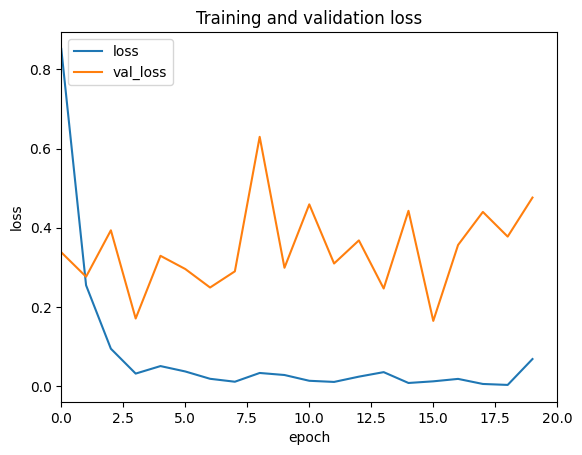

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlim([0.0, EPOCHS])
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()

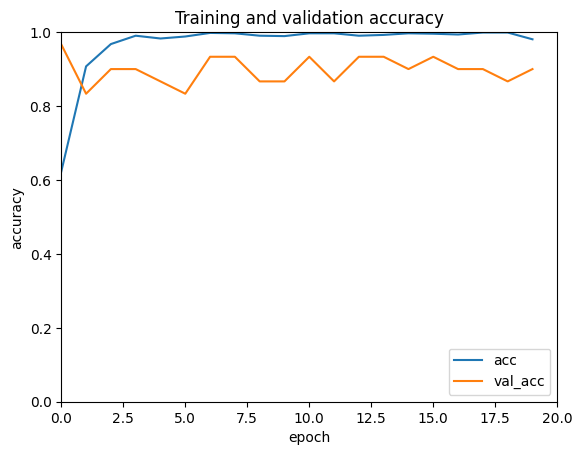

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.xlim([0.0, EPOCHS])
plt.ylim([0.0, 1.0])
plt.legend(['acc', 'val_acc'], loc='lower right')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


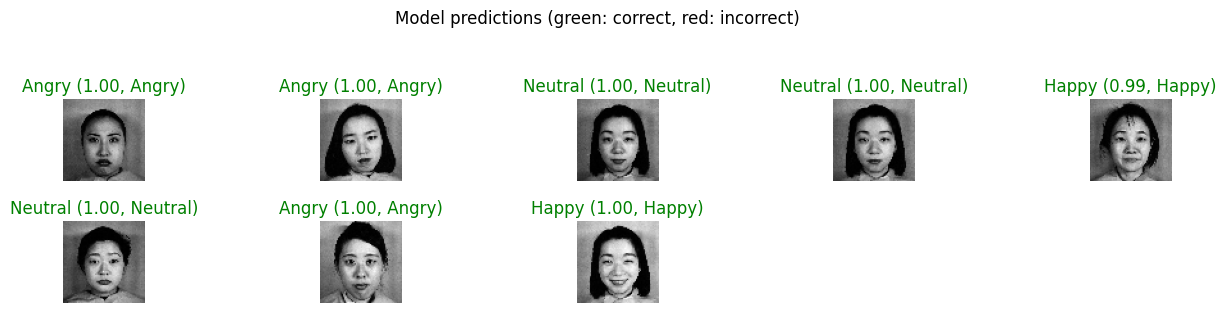

In [ ]:
# Get the ordered list of class names:
import PIL.Image as Image
class_names = validation_data.class_indices.items()
class_names = np.array([key.title() for key, value in class_names])

validation_data.reset()
validation_data.shuffle = True
validation_data.batch_size = BATCH_SIZE

# Retrieve the first batch from the validation data
for validation_image_batch, validation_label_batch in validation_data:
  break

validation_id = np.argmax(validation_label_batch, axis=-1)
validation_label = class_names[validation_id]
predicted_batch = model.predict(validation_image_batch)

# Returns the indices of the maximum values along a given axis
predicted_id = np.argmax(predicted_batch, axis=-1)

# Return the maximum values along a given axis
predicted_score = np.max(predicted_batch, axis=-1)

predicted_label_batch = class_names[predicted_id]

plt.figure(figsize=(16, 9))
plt.subplots_adjust(hspace=0.5)

# Display the classification results for the first 30 images
for n in range(min(validation_image_batch.shape[0], 30)):
  plt.subplot(6, 5, n + 1)

  # Convert the range from -1 to 1 to the range from 0 to 1
  plt.imshow(np.array(validation_image_batch[n]*255,np.int32))
  color = 'green' if predicted_id[n] == validation_id[n] else 'red'
  predicted_label = predicted_label_batch[n].title()
  plt.title(predicted_label + ' ({:.2f}, {})'.format(
      predicted_score[n], validation_label[n]), color=color)
  plt.axis('off')

_ = plt.suptitle('Model predictions (green: correct, red: incorrect)')

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
validation_data.reset()
validation_data.shuffle =  False
validation_data.batch_size = 1

In [ ]:
# Retrieve the first batch from the validation data
#for validation_image_batch, validation_label_batch in validation_data:
  #break
#predicted = model.predict_generator(validation_data, steps=validation_data.n)
#predicted_classes = np.argmax(predicted, axis=-1)

In [ ]:
# Retrieve the first batch from the validation data
for validation_image_batch, validation_label_batch in validation_data:
  break
predicted = model.predict(validation_data, steps=validation_data.n)
predicted_classes = np.argmax(predicted, axis=-1)

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [ ]:
# Apply normalization
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
cm = confusion_matrix(validation_data.classes, predicted_classes)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12, 9))

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

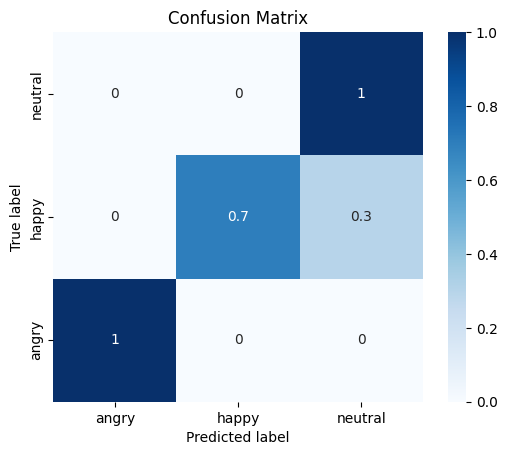

In [ ]:
# https://seaborn.pydata.org/generated/seaborn.heatmap.html
# https://matplotlib.org/users/colormaps.html
sns.heatmap(cm, annot=True, square=True, cmap=plt.cm.Blues,
            xticklabels=validation_data.class_indices,
            yticklabels=validation_data.class_indices)

plt.title("Confusion Matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.xlim([0.0, 3.0])
plt.ylim([0.0, 3.0])
plt.show()

## モデル保存

In [ ]:
#efficientnet 学習はエラーがでるので、モデル保存はパス
#save_model_path = os.path.join(backup_dir, 'efficientnet_model.h5')
#efficientnet_model.save(save_model_path)

NameError: name 'efficientnet_model' is not defined

In [ ]:
save_model_path = os.path.join(backup_dir, 'my_model_aug.h5')
model.save(save_model_path)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!cp './model/efficientnet_model.h5' '/content/drive/My Drive'
!cp './model/my_model_aug.h5' '/content/drive/My Drive'
!cp './model/labels.txt' '/content/drive/My Drive'

# 参考リンク

- https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb
- http://ni4muraano.hatenablog.com/entry/2019/06/16/084011
- https://qiita.com/wakame1367/items/d90fa56bd9d11c4db50e